**todo umer:** add masking for loading in all subkernels

(Started) implementation of a naive triton kernel for hqq-fwd, for axis=1.

**Naming convention:**
- bsx  = block size along axis x
- idx  = index along axis x
- nidx = number of chunks along axis x

eg if len(x) = 10, and we divide x into chunks of size 2 (so 10/2=5 chunks), and are selecting the 4rd chunk (ie 6th and 7th value), then bsx=2, idx=4, nidx=5.

In [1]:
from IPython.core.debugger import set_trace

import os
import torch
import numpy as np
from itertools import product

from torch import tensor, cat, int32, float16 as fp16, bfloat16 as bf16, isclose
from tabulate import tabulate

import matplotlib.pyplot as plt


os.environ['TRITON_INTERPRET'] = '1'

import triton
import triton.language as tl
import triton_util as tu

const = tl.constexpr
cdiv, breakpoint_once, print_once = tu.cdiv, tu.breakpoint_once, tu.print_once

torch.set_printoptions(linewidth=200, precision=2, sci_mode=False)
np.set_printoptions(linewidth=200, precision=2) # for triton simulator

In [2]:
dtype = fp16 # can't use bf16 with triton simulator, as numpy doesn't support bf16

In [3]:
b,m,r,n = 2,128,32,64 # batch size, out, lora rank, in
gz, gz2, pz = 64, 128, 10    # group size, group size for quanting zero & scale, pack size (needs to be 10, as we pack 10 x 3bit -> 32bit)

n_p = cdiv(gz,  pz) # number of packs per group (can't name it np due to numpy)
ng  = cdiv(m*n, gz) # number of groups
ng2 = cdiv(ng , gz2)# number of groups for quanting zero/scale

print(f'{n_p = }, {ng = }, {ng2 = }')

n_p = 7, ng = 128, ng2 = 1


In [4]:
assert ng%gz2==0, f'num_groups ({ng}) needs to divide group_size_2 ({gz2}) for quanting of zero & scale to work'
print(f'num_groups ({ng}) divides group_size_2 ({gz2}) ✓')

num_groups (128) divides group_size_2 (128) ✓


In [5]:
def ones(*shape):      return torch.ones(shape, dtype=dtype, device='cuda')
def zeros(*shape):     return torch.zeros(shape, dtype=dtype, device='cuda')
def rand(*shape):      return torch.randn(shape, dtype=dtype, device='cuda')
def rand_3bit(*shape): return torch.randint(low=0, high=7, size=shape, dtype=dtype, device='cuda')

X, A, B = ones(b,n), ones(r,n), ones(m,r)

mag = ones(m) # magnitude
α = 0.9

scale_q, zero_q = ones(gz2, ng2), ones(gz2, ng2)

s_scale, s_zero, z_scale, z_zero = ones(1, ng2), ones(1, ng2), ones(1, ng2), ones(1, ng2)

packed_value = (1 << 29) + (1 << 26)  # first 2 packs set to 1, other 0: 001 001 00000000000000000000000000

bit_repr = [int(o) for o in format(packed_value & 0xFFFFFFFF, '032b')]
assert sum(bit_repr)==2 # only 2 ones...
assert (bit_repr[2], bit_repr[5])==(1,1) # ... at location 2 and 5 

W_qp = torch.full((n_p,ng), packed_value, dtype=int32)

In [6]:
W_qp[:3,:3]

tensor([[603979776, 603979776, 603979776],
        [603979776, 603979776, 603979776],
        [603979776, 603979776, 603979776]], dtype=torch.int32)

In [7]:
W_shape = (m, n)
zero_scale_shape = (1, ng)
print(f'{W_shape = }, {zero_scale_shape = }')

W_shape = (128, 64), zero_scale_shape = (1, 128)


In [8]:
def assert_close(out, expected, do_print=True, atol=None):
    if do_print:
        print('output:',out)
        print('expected:',expected)
    if atol is None: atol = 1e-5
    assert torch.isclose(out, expected,atol=atol).all(), 'Not close 🤔'
    print('Equal ✅')

Many subkernels will compute a block of an overall result. Let's have a function that collects the blocks, so we can compare it to the overall expected output.

In [9]:
def compute_block_wise_and_compare(expected, fn, dims, step_szs, do_print=False, atol=None, do_return=False, do_plot_err=False):
    out = zeros(*dims)
    for ids in product(*[range(cdiv(dim,bs_dim)) for dim, bs_dim in zip(dims,step_szs)]): # iterate over grid over dims; each step has shape cdiv(dim,bs_dim) for each dim
        # compute out_block
        out_block = zeros(*step_szs)
        fn(out_block, *ids)
        # compute where to store out_block in out
        slices_out, slices_block = [], []
        for idx, dim, bs_dim in zip(ids, dims, step_szs):
            # determine location of out_patch in out
            min_id =  idx   *bs_dim
            max_id = (idx+1)*bs_dim
            # don't go out of bounds
            max_id = min(max_id, dim)
            # save location to be used below
            slices_out  .append(slice(min_id, max_id))
            slices_block.append(slice(0, max_id - min_id))
        # store out_block into out
        out[tuple(slices_out)] = out_block[tuple(slices_block)]
    if do_plot_err:
        err = (out-expected).abs().cpu()
        if len(err.shape)==1: err = err[None,:]
        plt.imshow(err, vmin=0, vmax=err.max())
        plt.colorbar()
        plt.show()
    if do_return: return out
    assert_close(out, expected, do_print=do_print, atol=atol)

### Sub-Kernel 1: Load & Dequant zero / scale

In [10]:
@triton.jit
def dequant_zero_or_scale(vals_ptr, zero_ptr, scale_ptr, gz2: const, ng2: const, shape: const):
    vals_q = tu.load_full_2d(vals_ptr,  sz0=gz2, sz1=ng2, stride0=ng2) # quanted zero/scale values; ~ (gz2, ng2)
    zero   = tu.load_full_1d(zero_ptr,  sz=ng2)                        # zero  of zero/scale;       ~ (ng2)
    scale  = tu.load_full_1d(scale_ptr, sz=ng2)                        # scale of zero/scale;       ~ (ng2)
    vals = (vals_q-zero)*scale
    return vals.reshape(shape)

In [11]:
@triton.jit
def test_dequant_zero_or_scale(out_ptr, vals_ptr, zero_ptr, scale_ptr, gz2: const, ng2: const, shape: const):
    out = dequant_zero_or_scale(vals_ptr, zero_ptr, scale_ptr, gz2, ng2, shape)
    tu.store_full_2d(out, out_ptr, shape[0], shape[1], stride0=shape[1])

zvals = torch.ones((gz2, ng2), device='cuda', dtype=dtype) * 1
zzero = torch.ones((1,   ng2), device='cuda', dtype=dtype) * 2
zscale= torch.ones((1,   ng2), device='cuda', dtype=dtype) * 3
out  = torch.zeros((ng, 1),  device='cuda', dtype=dtype)

test_dequant_zero_or_scale[(1,)](out, zvals, zzero, zscale, gz2, ng2, (ng,1))

In [12]:
assert_close(out, (zvals-zzero)*zscale, do_print=False)

Equal ✅


### Sub-Kernel 2: Load, unpack W_qp

In [13]:
from hqq.core.bitpack import BitPack

In [14]:
DEBUG = False

@triton.jit
def load_W_q(ptr, bsm: const, idm: const, m: const, n: const, gz: const, pz: const):
    '''Load selected rows from W_qp (and all cols)'''

    if DEBUG: print_once('---- Running load_W_q ----')
    if DEBUG: print_once(f'bsm = {bsm}, idm = {idm}, m = {m}, n = {n}, gz = {gz}, pz = {pz}')
    
    offs   = tu.offset_1d(bsm, idm)  # rows of W
    if DEBUG: print_once(f'W rows = {offs}')    
    if DEBUG: print_once(f'grouping multiplier = {n/gz}')    
    
    offs_q = tu.offset_1d(bsm*(n//gz), idm) # rows of W_q ; note: n/gz is integer    
    if DEBUG: print_once(f'W_q rows = {offs_q}')    
    
    npacks = cdiv(m*n//gz, 10)         # number of packed values
    if DEBUG: print_once(f'npacks = {npacks}')    
    
    offs0  = offs_q % npacks           # rows of W_qp
    if DEBUG: print_once(f'W_qp rows = {offs0}')    
    
    shifts = 27 - 3*(offs_q // npacks) # right-shifts needed to unpack correctly, for each row    
    if DEBUG: print_once(f'shifts = {shifts}')    
    
    offs1 = tl.arange(0, gz) # all cols
    if DEBUG: print_once(f'offs1 = {offs1}')    
    
    w_pq_offs = tu.offset_2d(offs0, offs1, stride0=gz)
    if DEBUG: print_once(f'w_pq_offs =\n{w_pq_offs}')    

    w_pq_mask = tu.mask_2d  (offs0, offs1, max0=m*n//gz, max1=gz)
    if DEBUG: print_once(f'w_pq_mask =\n{w_pq_mask}')    

    vals = tl.load(ptr + w_pq_offs, w_pq_mask)
    if DEBUG: print_once(f'vals =\n{vals}')    

    shifted_vals = vals >> shifts[:,None] & 0b111
    if DEBUG: print_once(f'shifted_vals =\n{shifted_vals}')    
    
    return shifted_vals

Let's test it with random 3bit values, for a weight matrix W of size `8x4`

In [15]:
@triton.jit
def test_load_W_q(out_ptr, W_qp_ptr, idm: const, bsm: const, m: const, n: const, gz: const, pz: const):
    W_q = load_W_q(W_qp_ptr, bsm, idm, m, n, gz, pz)
    tu.store_full_2d(W_q, out_ptr, bsm, gz, gz)

In [16]:
m,n=8,4
gz = 4

rand_mat = rand_3bit(m,n)
rand_packed = BitPack.pack_3bit_32(rand_mat.reshape(-1,gz))
rand_mat.shape, rand_packed.shape, m, n, gz, pz

(torch.Size([8, 4]), torch.Size([1, 4]), 8, 4, 4, 10)

In [17]:
bsm=2
for idm in [0,1]:
    print(f'-- idm = {idm}')
    small_bsm = 2
    out = zeros(bsm*(n//gz), gz)
    test_load_W_q[(1,1)](out, rand_packed, idm, bsm, m, n, gz, pz)
    assert_close(out.half(), rand_mat[idm*bsm:(idm+1)*bsm,:].reshape(-1,gz))

-- idm = 0
output: tensor([[5., 5., 3., 5.],
        [6., 5., 6., 3.]], device='cuda:0', dtype=torch.float16)
expected: tensor([[5., 5., 3., 5.],
        [6., 5., 6., 3.]], device='cuda:0', dtype=torch.float16)
Equal ✅
-- idm = 1
output: tensor([[2., 2., 4., 1.],
        [5., 4., 4., 3.]], device='cuda:0', dtype=torch.float16)
expected: tensor([[2., 2., 4., 1.],
        [5., 4., 4., 3.]], device='cuda:0', dtype=torch.float16)
Equal ✅


### Sub-Kernel 3: Dequant W

In [18]:
@triton.jit
def dequant_W(W_q, zero, scale, bsm: const, n:const):
    return ((W_q-zero)*scale).reshape(bsm,n)

In [19]:
@triton.jit
def test_dequant_W(out_ptr, vals_ptr, zero_ptr, scale_ptr, bsm: const, n: const, gz: const):
    W_q   = tu.load_full_2d(vals_ptr,  bsm*n//gz, gz, gz)
    zero  = tu.load_full_2d(zero_ptr,  bsm*n//gz, 1,   1)
    scale = tu.load_full_2d(scale_ptr, bsm*n//gz, 1,   1)
    W = dequant_W(W_q, zero, scale, bsm, n)
    tu.store_full_2d(W, out_ptr, bsm, n, n)

In [20]:
bsm = 2
m,n=8,4
gz = 2

vals = ones(bsm*n//gz, gz) * 1
zero = ones(bsm*n//gz,  1) * 2
scale= ones(bsm*n//gz,  1) * 3
out  = zeros(bsm, n)

In [21]:
test_dequant_W[(1,)](out, vals, zero, scale, bsm, n, gz)

In [22]:
assert_close(out, ((vals-zero)*scale).reshape(-1,n))

output: tensor([[-3., -3., -3., -3.],
        [-3., -3., -3., -3.]], device='cuda:0', dtype=torch.float16)
expected: tensor([[-3., -3., -3., -3.],
        [-3., -3., -3., -3.]], device='cuda:0', dtype=torch.float16)
Equal ✅


### Sub-Kernel 4: `x@w.t`

In [23]:
# input:
# 1. x[b-chunk,:]
# 2. w[m-chunk,:]
# output x@w.t[b-chunk,m-chunk]

In [24]:
@triton.jit
def batched_matmul(
    x_ptr, w_ptr,                       # pointers
    bsb: const, bsm: const, bsn: const, # block sizes
    idb, idm,                           # block indices
    b:const, n:const,                   # matrix sizes
):
    # 1d offets along b,m,n axes
    offs_b = tu.offset_1d(bsb, idb)
    offs_m = tu.offset_1d(bsm, idm)
    offs_n = tu.offset_1d(bsn, 0)
    # 2d offsets of x, w
    offs_x = x_ptr + tu.offset_2d(offs_b, offs_n, n)
    offs_w = w_ptr + tu.offset_2d(offs_m, offs_n, n)
    # initialize and iteratively update accumulator
    acc = tl.zeros((bsb, bsm), dtype=tl.float32)
    for _ in range(0, n, bsn):
        x = tl.load(offs_x)
        w = tl.load(offs_w)
        acc += tl.dot(x, w.trans(), allow_tf32=False) # allow_tf32 must be set to False for older GPUs, otherwise won't compile
        # increase offsets, so next iteration loads next chunks
        offs_x += bsn
        offs_w += bsn
    return acc

In [25]:
@triton.jit
def test_batched_mamtul(
    out_ptr,
    x_ptr, w_ptr,                       # pointers
    bsb: const, bsm: const, bsn: const, # block sizes
    idb, idm,                           # block indices
    b:const, n:const,                   # matrix sizes
):
    out = batched_matmul(x_ptr, w_ptr, bsb, bsm, bsn, idb, idm, b, n)
    tu.store_full_2d(out, out_ptr, bsb, bsm, bsm)

Test it with small 1-matrices

In [26]:
b,m,n = 16, 16, 16
bsb,bsm,bsn = 16,16,16 # tl.dot requires all axes to be >= 16

x = ones(b,n)
w = ones(m,n)
out = zeros(bsb,bsm)

compute_block_wise_and_compare(
    expected= x@w.t(),
    fn      = lambda out_block, idb, idm: test_batched_mamtul[(1,)](out_block, x, w, bsb, bsm, bsn, idb, idm, b,n),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with larger 1-matrices

In [27]:
b,m,n = 128, 128, 128
bsb,bsm,bsn = 32,32,16 # tl.dot requires all axes to be >= 16

x = ones(b,n)
w = ones(m,n)

compute_block_wise_and_compare(
    expected= x@w.t(),
    fn      = lambda out_block, idb, idm: test_batched_mamtul[(1,)](out_block, x, w, bsb, bsm, bsn, idb, idm, b,n),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with larger random matrices (note: for easier debugging, keep random matrix creation & execution in different cells).

In [28]:
b,m,n = 128, 128, 128
bsb,bsm,bsn = 32,32,16 # tl.dot requires all axes to be >= 16

x = rand(b,n)
w = rand(m,n)

In [29]:
compute_block_wise_and_compare(
    expected= x@w.t(),
    fn      = lambda out_block, idb, idm: test_batched_mamtul[(1,)](out_block, x, w, bsb, bsm, bsn, idb, idm, b,n),
    dims=(b,m), step_szs=(bsb, bsm),
    atol=0.5
)

Equal ✅


### Sub-Kernel 5: `x@a.t@b.t`

In [30]:
# input: x[b-chunk,:], a[:,:], b[m-chunk,:]
# output: (x@a.t@b@t)[b-chunk, m-chunk]

In [31]:
@triton.jit
def batched_double_matmul(
    x_ptr, a_ptr, b_ptr,                            # pointers
    bsb: const, bsm: const, bsn: const, bsr: const, # block sizes
    idb, idm,                                       # block indices
    n, r                                            # matrix sizes
):
    # 1d offets along b,m,n,r axes
    offs_b = tu.offset_1d(bsb, idb)
    offs_m = tu.offset_1d(bsm, idm)
    offs_n = tu.offset_1d(bsn, 0)
    offs_r = tu.offset_1d(bsr, 0)
    # 2d offsets of x,a,b
    offs_x = x_ptr + tu.offset_2d(offs_b, offs_n, n)
    offs_a = a_ptr + tu.offset_2d(offs_r, offs_n, n)
    offs_b = b_ptr + tu.offset_2d(offs_m, offs_r, r)
    # initialize and iteratively update accumulator
    acc = tl.zeros((bsb, bsm), dtype=tl.float32)
    for idn in range(0, n, bsn):
        x = tl.load(offs_x) # load x chunk (axis: b, n)
        for idr in range(0, r, bsr):
            a = tl.load(offs_a) # load a chunk (axis: r,n)
            b = tl.load(offs_b) # load a chunk (axis: m,r)
            acc += tl.dot( # multiply x with a.t, cast result to fp16, then multiply with b.t 
                tl.dot(x, a.trans(), allow_tf32=False).to(tl.float16),
                b.trans(),
                allow_tf32=False
            ) # allow_tf32 must be set to False for older GPUs, otherwise won't compile
            # increase offsets, so next iteration loads next chunks
            offs_a += bsr * n # advance a by bsr rows
            offs_b += bsr     # advance b by bsr cols
        offs_a = a_ptr + tu.offset_2d(offs_r, offs_n, n) # reset advancement of a
        offs_b = b_ptr + tu.offset_2d(offs_m, offs_r, r) # reset advancement of b
        offs_a += bsn # advance a by bsn cols
        offs_x += bsn
    return acc

In [32]:
@triton.jit
def test_batched_double_matmul(
    out_ptr,
    x_ptr, a_ptr, b_ptr,                            # pointers
    bsb: const, bsm: const, bsn: const, bsr: const, # block sizes
    idb, idm,                                       # block indices
    n, r                                            # matrix sizes
):
    out = batched_double_matmul(x_ptr, a_ptr, b_ptr, bsb, bsm, bsn, bsr, idb, idm, n, r)
    tu.store_full_2d(out, out_ptr, bsb, bsm, bsm)

Test it with small 1-matrices

In [33]:
b,m,n,r         = 16,16,16,16
bsb,bsm,bsn,bsr = 16,16,16,16 # tl.dot requires all axes to be >= 16

# capitalize due to name conflict for b
X = ones(b,n)
A = ones(r,n)
B = ones(m,r)

compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with large 1-matrices

In [34]:
b,m,n,r         = 128,128,128,128
bsb,bsm,bsn,bsr =  64, 64, 32, 32 # tl.dot requires all axes to be >= 16

# capitalize due to name conflict for b
X = ones(b,n)
A = ones(r,n)
B = ones(m,r)

compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with small random matrices

In [35]:
b,m,n,r         =  16, 16, 16, 16
bsb,bsm,bsn,bsr =  16, 16, 16, 16
X, A, B = rand(b,n), rand(r,n), rand(m,r)

In [36]:
compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with mid-sized random 3bit matrices

In [37]:
b,m,n,r         =  16, 16, 32, 32
bsb,bsm,bsn,bsr =  16, 16, 16, 16
X, A, B = rand_3bit(b,n), rand_3bit(r,n), rand_3bit(m,r)

In [38]:
compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


Test it with large random 3bit matrices

In [39]:
b,m,n,r         =  128, 128, 128, 128
bsb,bsm,bsn,bsr =   64,  64,  32,  32
X, A, B = rand_3bit(b,n), rand_3bit(r,n), rand_3bit(m,r)

In [40]:
compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm)
)

Equal ✅


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/triton/runtime/interpreter.py:391: RuntimeWarning: overflow encountered in cast
  return TensorHandle(src.data.astype(_get_np_dtype(dst_type)), dst_type.scalar)


Note: Overflow, because even average size of values above is larger than max of float16 (`3.5*3.5*128*128` = ~200k > 65,504)

Test it with mid-sized random matrices

In [41]:
b,m,n,r         =  16, 16, 32, 32
bsb,bsm,bsn,bsr =  16, 16, 16, 16
X, A, B = rand(b,n), rand(r,n), rand(m,r)

In [42]:
compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims=(b,m), step_szs=(bsb, bsm),
    atol = 0.08
)

Equal ✅


Test it with large random matrices

Note: This test 'fails' because we're adding up a lot (128*128=~16k) small errors, so the resulting error for each value is large. But the error distribution is exp, so nothing out of the ordinary. So this is expected.

In [43]:
b,m,n,r         = 128,128,128,128
bsb,bsm,bsn,bsr =  64, 64, 32, 32 # tl.dot requires all axes to be >= 16

X = torch.rand((b,n), dtype=dtype, device='cuda')
A = torch.rand((r,n), dtype=dtype, device='cuda')
B = torch.rand((m,r), dtype=dtype, device='cuda')

In [44]:
#compute_block_wise_and_compare(
#    expected= X@A.t()@B.t(),
#    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
#    dims    = (b,m), step_szs= (bsb, bsm), atol=1
#)

Verify error distribution is randomly distributed among the cells:

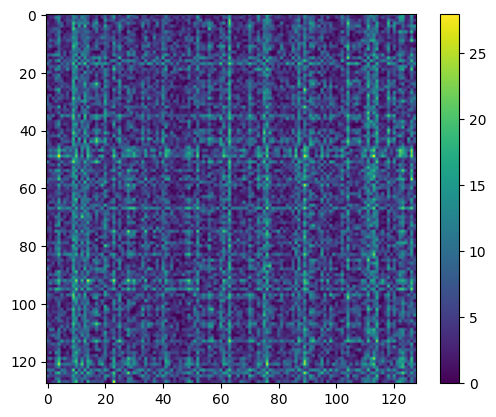

In [45]:
out = compute_block_wise_and_compare(
    expected= X@A.t()@B.t(),
    fn      = lambda out_block, idb, idm: test_batched_double_matmul[(1,)](out_block, X,A,B , bsb, bsm, bsn, bsr, idb, idm, n,r),
    dims    = (b,m), step_szs= (bsb, bsm),
    do_plot_err=True,
    do_return=True
)

Verify abs error distribution is exponentially distributed:

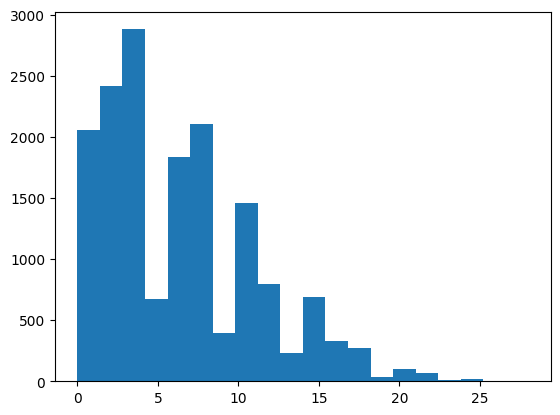

In [46]:
err = out - X@A.t()@B.t()
plt.hist(err.abs().flatten().cpu(), bins=20);

### Sub-Kernel 6: colnorm

In [47]:
# input:
# - w[m-chunk,:]
# - a[:,:]
# - b[m-chunk,:]
# output: col_norm[m-chunk]

In [48]:
@triton.jit
def col_norm(
    w_ptr, a_ptr, b_ptr,                # pointers
    bsm: const, bsn: const, bsr: const, # block sizes
    idm,                                # block indices
    n, r                                # matrix sizes
):
    # 1d offets along m,n,r axes
    offs_m = tu.offset_1d(bsm, idm)
    offs_n = tu.offset_1d(bsn, 0)
    offs_r = tu.offset_1d(bsr, 0)
    # 2d offsets of x,a,b
    offs_w = w_ptr + tu.offset_2d(offs_m, offs_n, n)
    # initialize and iteratively update accumulator for colnorm, using a regular matmul to compute b@a
    acc_colnorm = tl.zeros((bsm,bsn), dtype=tl.float32)  # accumulator for colnorm
    for idb in range(0, n, bsn):
        acc_mm = tl.zeros((bsm, bsn), dtype=tl.float32) # initialize accumulator for matmul
        # initialize / reset offsets for a & b
        offs_a = a_ptr + tu.offset_2d(offs_r, offs_n, n)
        offs_b = b_ptr + tu.offset_2d(offs_m, offs_r, r)        
        for idr in range(0, r, bsr):
            a = tl.load(offs_a)
            b = tl.load(offs_b)
            acc_mm += tl.dot(b, a, allow_tf32=False) # allow_tf32 must be set to False for older GPUs, otherwise won't compile
            # increase offsets, so next iteration loads next chunks
            offs_a += bsr*n # advance a by bsr rows
            offs_b += bsr   # advance b by bsr cols
        w = tl.load(offs_w)
        # update accumulator for colnorm
        acc_colnorm += (acc_mm+w)*(acc_mm+w)
    return tl.sqrt(tl.sum(acc_colnorm, axis=1))

In [49]:
@triton.jit
def test_col_norm(
    out_ptr,
    w_ptr, a_ptr, b_ptr,                # pointers
    bsm: const, bsn: const, bsr: const, # block sizes
    idm,                                # block indices
    n, r                                # matrix sizes
):
    out = col_norm(w_ptr, a_ptr, b_ptr, bsm, bsn, bsr, idm, n, r)
    tu.store_full_1d(out, out_ptr, bsm)

Test it with small 1-matrices

In [50]:
m,n,r       = 16,16,16
bsm,bsn,bsr = 16,16,16 # tl.dot requires all axes to be >= 16

# capitalize due to name conflict for b
W = ones(m,n)
A = ones(r,n)
B = ones(m,r)

compute_block_wise_and_compare(
    expected= ((W+B@A)**2).sum(axis=1).sqrt(),
    fn      = lambda out_block, idm: test_col_norm[(1,)](out_block, W,A,B ,  bsm, bsn, bsr, idm, n,r),
    dims=(m,), step_szs=(bsm,), do_print=True
)

output: tensor([68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68.], device='cuda:0', dtype=torch.float16)
expected: tensor([68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68., 68.], device='cuda:0', dtype=torch.float16)
Equal ✅


Test it with large 1-matrices

In [51]:
m,n,r       = 128,128,128
bsm,bsn,bsr =  32, 16, 16 # tl.dot requires all axes to be >= 16

# capitalize due to name conflict for b
W = ones(m,n) * 0.01 # make small, due prevent overflow
A = ones(r,n) * 0.1
B = ones(m,r) * 0.1

out = compute_block_wise_and_compare(
    expected= ((W+B@A)**2).sum(axis=1).sqrt(),
    fn      = lambda out_block, idm: test_col_norm[(1,)](out_block, W,A,B ,  bsm, bsn, bsr, idm, n,r),
    dims=(m,), step_szs=(bsm,), atol=1e-3
)

Equal ✅


Test it with small random matrices

In [52]:
m,n,r       =  32, 32, 32
bsm,bsn,bsr =  16, 16, 16 # tl.dot requires all axes to be >= 16

# capitalize due to name conflict for b
W = rand(m,n) * 0.01 # make small, due prevent overflow
A = rand(r,n) * 0.1
B = rand(m,r) * 0.1

In [53]:
out = compute_block_wise_and_compare(
    expected= ((W+B@A)**2).sum(axis=1).sqrt(),
    fn      = lambda out_block, idm: test_col_norm[(1,)](out_block, W,A,B ,  bsm, bsn, bsr, idm, n,r),
    dims=(m,), step_szs=(bsm,), atol=0.15
)

Equal ✅


### Sub-Kernel 7: `* α, mag, 1/colnorm`

In [54]:
# input: y, alpha, mag, colnorm
# output: y*alpha*mag/colnorm

In [55]:
@triton.jit
def pointwise_mul(y, mag_ptr, colnorm, α, bsm: const, idm, m):
    mag = tu.load_1d(mag_ptr, bsm, idm, m)
    return y * mag[None,:] * colnorm[None,:] * α

In [56]:
@triton.jit
def test_pointwise_mul(out_ptr, y_ptr, mag_ptr, colnorm_ptr, α, bsb: const, bsm: const, idb, idm, b, m):
    y       = tu.load_2d(y_ptr, bsb, bsm, idb, idm, b, m, m)
    colnorm = tu.load_1d(colnorm_ptr, bsm, idm, m)    
    out = pointwise_mul(y, mag_ptr, colnorm, α, bsm, idm, m)
    tu.store_2d(out, out_ptr, bsb, bsm, idb, idm, b, m, m)

Test it with small 1-matrices

In [57]:
b,m     = 16,16
bsb,bsm = 16,16 # tl.dot requires all axes to be >= 16

α       = 2 
y       = ones(b,m)
colnorm = ones(m)
mag     = ones(m)

compute_block_wise_and_compare(
    expected= y*mag[None,:]/colnorm[None,:]*α,
    fn      = lambda out_block, idb, idm: test_pointwise_mul[(1,)](out_block, y, mag, colnorm, α, bsb, bsm, idb, idm, b, m),
    dims=(b,m), step_szs=(bsb,bsm)
)

Equal ✅


Test it with mid-sizes 1-matrices

In [ ]:
b,m     = 128, 128
bsb,bsm =  32,  32 # tl.dot requires all axes to be >= 16

α       = 2 
y       = ones(b,m)
colnorm = ones(m)
mag     = ones(m)

compute_block_wise_and_compare(
    expected= y*mag[None,:]/colnorm[None,:]*α,
    fn      = lambda out_block, idb, idm: test_pointwise_mul[(1,)](out_block, y, mag, colnorm, α, bsb, bsm, idb, idm, b, m),
    dims=(b,m), step_szs=(bsb,bsm)
)

### Full Kernel

In [ ]:
def fwd_op(fwd_k, bsb, bsm, bsr, bsn):
    # for simplicity, following vars are used from closure & will instead be passed in actual op:
    #   X, A, B, W_qp, scale_q, zero_q,
    #   mag, s_scale, s_zero, z_scale, z_zero
    #   α
    #   W_shape, zero_scale_shape 
    # these vars will be computed from in actual op, but are also used from closure for simplicity
    #   b,m,r,n

    Y = torch.zeros((b,m),dtype=bf16, device='cuda')
    assert_tensors_gpu_ready(Y, X, A, B, mag, scale_q, zero_q, s_scale, s_zero, z_scale, z_zero, W_qp)

    grid = (cdiv(b, bsb), cdiv(m, bsm))
    print(f'Launching grid of size {grid}')
    
    fwd_k[grid](
        # input matrices
        X, A, B, W_qp, scale_q, zero_q, 
        # input vectors
        mag, s_scale, s_zero, z_scale, z_zero,
        # input scalars
        α,
        # output matrix
        Y,
        # dimensions
        b,m,r,n,
        # grouping / packing configs
        gz, gz2, pz,
        # shapes to undo grouping
        W_shape, zero_scale_shape,
        # block sizes
        bsb, bsm, bsr, bsn
        # strides
        # todo
    )
    return Y

In [ ]:
# # total todo:
# dequant zero & scale
# unpack w
# dequant w    
# x@w.t
# x@a.t@b.t
# build colnorm
# times alpha, mag, 1/colnorm

@triton.jit
def forward_k(
    # input matrices
    X_ptr, A_ptr, B_ptr, W_qp_ptr, scale_q_ptr, zero_q_ptr,
    # input vectors
    mag_ptr, s_scale_ptr, s_zero_ptr, z_scale_ptr, z_zero_ptr,
    # input scalars
    α,
    # output matrix
    Y_ptr,
    # dimensions
    b: tl.constexpr, m: tl.constexpr, r: tl.constexpr, n: tl.constexpr,
    # grouping / packing configs
    gz: tl.constexpr, gz2: tl.constexpr, pz: tl.constexpr,
    # shapes to undo grouping
    W_shape: tl.constexpr, zero_scale_shape: tl.constexpr, 
    # block sizes
    bsb: tl.constexpr, bsm: tl.constexpr, bsr: tl.constexpr, bsn: tl.constexpr,
    # strides
    # todo
):
    tl.static_assert(m%gz and n%gz, f'group_size ({gz}) must divide m ({m}) and n ({n})')
    
    pid0, pid1 = tl.program_id(0), tl.program_id(1) # blocks correspond to chunking of b and m axes

    n_p: tl.constexpr  = cdiv(gz,  pz)  # number of packs per group (can't name it np due to numpy)
    ng:  tl.constexpr  = cdiv(m*n, gz)  # number of groups
    ng2: tl.constexpr  = cdiv(ng,  gz2) # number of groups for quanting zero/scale
    
    # # dequant zero & scale
    zero  = dequant_zero_or_scale(zero_q_ptr,  z_zero_ptr, z_scale_ptr,  gz2, ng2, shape=zero_scale_shape)
    scale = dequant_zero_or_scale(scale_q_ptr, s_zero_ptr, s_scale_ptr,  gz2, ng2, shape=zero_scale_shape)
    # # unpack w
    qp_row_lo, qp_row_hi = rows_in_W_pq(bsm, pid1, m, n, gz, pz)        # determine which rows of W_qp are relevant
    w_qp = load_W_qp(W_qp_ptr, qp_row_lo, qp_row_hi, row_max=n_p, ng=ng) # load those rows (and all cols)

    breakpoint_once()

    
    # dequant w
    
    # x@w.t
    # x@a.t@b.t
    # build colnorm
    # times alpha, mag, 1/colnorm
    
    pass

In [ ]:
block_sizes = dict(bsb=2, bsm=2, bsr=2, bsn=2)
fwd_op(forward_k, **block_sizes)

In [ ]:
raise ValueError()

In [ ]:
def qp_rows(lo, hi, pz, gz, m, n):
    assert m%gz==n%gz==0, 'gz must divide m and n'
    qlo, qhi = lo*n//gz, hi*n//gz
    npacks = cdiv((m*n//gz), 10)
    plo, phi = qlo%npacks, qhi%npacks
    print(f'groups = {int(m*n/gz)}, packs = {npacks}')
    print(f'rows: {lo},{hi}\nquanted rows: {qlo}, {qhi}\npacked rows: {plo}, {phi}')

In [ ]:
qp_rows(10, 14, pz, gz, m, n)

In [ ]:
m,n,gz

In [ ]:
cdiv??